In [11]:
import os
import numpy as np
import cv2   #if u have dimension error use cv2 for image read its better than 'from skimage.io import imread'
from tqdm import tqdm       
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from scipy import ndimage as nd
import bm3d
from scipy import ndimage, misc
from skimage import color, data, restoration
from skimage import img_as_float
import tensorflow as tf


In [17]:
TRAIN_PATH = 'C:\\Sarvesh\\Capstone\\labeled data\\training-data-ZA'
if os.path.exists(TRAIN_PATH):
    print(f"The path {TRAIN_PATH} exists.")
else:
    print(f"The path {TRAIN_PATH} does not exist.")

The path C:\Sarvesh\Capstone\labeled data\training-data-ZA exists.


In [26]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3


TRAIN_PATH = 'C:\\Sarvesh\\Capstone\\labeled_data\\training-data-ZA'

train_ids = next(os.walk(TRAIN_PATH))[1]
print('length of train IDs: ', len(train_ids))


X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),  dtype='bool')

print('X_train shape ', X_train.shape)
#print(X_train.dtype)
#print(X_train)

print('Y_train shape ', Y_train.shape)
#print(Y_train.dtype)
#print(Y_train)

length of train IDs:  1460
X_train shape  (1460, 320, 320, 3)
Y_train shape  (1460, 320, 320, 1)


In [38]:
alpha = 1.4 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)
psf = np.ones((5, 5)) / 25 # psf = point spread function for richardson_lucy algorithm
alpha = 1.4  # Contrast control (1.0-3.0)
beta = 0  # Brightness control (0-100)
psf = np.ones((5, 5)) / 25  # Point spread function for Richardson-Lucy algorithm

# FOR TRAINING IMAGES
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    
    img = img_as_float(cv2.imread(os.path.join(path, 'images', f'{id_}.jpeg')))
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    
    min_img = ndimage.filters.minimum_filter(img, size=3, output=None, mode='wrap', cval=0.0, origin=0)  # Morphological filter
    
    BM3D_denoised_image = bm3d.bm3d(min_img, sigma_psd=0.08, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING, profile='high')  # Denoising

    # Convert to grayscale if the image has multiple channels
    if BM3D_denoised_image.ndim == 3:
        BM3D_denoised_image = color.rgb2gray(BM3D_denoised_image)

    # Restore Image using Richardson-Lucy algorithm
    deconvolved_RL = restoration.richardson_lucy(BM3D_denoised_image, psf, num_iter=5)
    deconvolved_RL = (deconvolved_RL * 255).astype('uint8')

    # Adjust contrast and brightness
    adjusted = cv2.convertScaleAbs(deconvolved_RL, alpha=alpha, beta=beta)
    
    # Convert to RGB if needed
    if len(adjusted.shape) == 2:  # Check if the image is grayscale
        adj3d = color.gray2rgb(adjusted)
    else:
        adj3d = adjusted

    X_train[n] = adj3d
    
    # Process masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype='bool')
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = cv2.imread(path + '/masks/' + mask_file)
        mask_ = cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
        mask_ = mask_[:, :, :1]
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

print('done')

  0%|          | 0/1460 [00:00<?, ?it/s]C:\Users\Sarvesh Adithya J\AppData\Local\Temp\ipykernel_22976\3146969477.py:15: DeprecationWarning: Please import `minimum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  min_img = ndimage.filters.minimum_filter(img, size=3, output=None, mode='wrap', cval=0.0, origin=0)  # Morphological filter
100%|██████████| 1460/1460 [1:05:34<00:00,  2.69s/it]

done


In [40]:
import pickle

pickle_out = open("C:\\Sarvesh\\Capstone\\X_train_1006.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("C:\\Sarvesh\\Capstone\\Y_train_1006.pickle","wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()
'''
#We can always load it in to our current script, or a totally new one by doing:

pickle_in = open("/kaggle/input/intraretinal-cystoid-fluid/X_train_1006.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("/kaggle/input/intraretinal-cystoid-fluid/Y_train_1006.pickle","rb")
Y_train = pickle.load(pickle_in)
'''

'\n#We can always load it in to our current script, or a totally new one by doing:\n\npickle_in = open("/kaggle/input/intraretinal-cystoid-fluid/X_train_1006.pickle","rb")\nX_train = pickle.load(pickle_in)\n\npickle_in = open("/kaggle/input/intraretinal-cystoid-fluid/Y_train_1006.pickle","rb")\nY_train = pickle.load(pickle_in)\n'

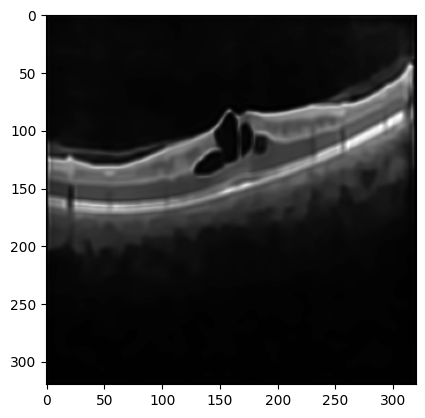

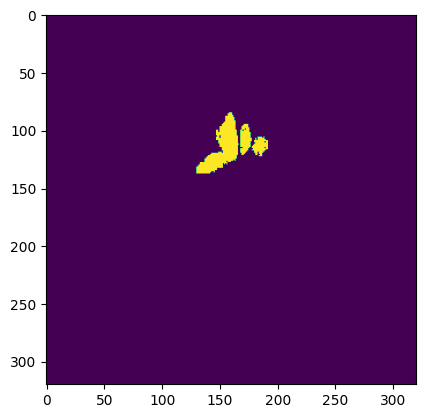

In [41]:
plt.imshow(X_train[9])
plt.show()
plt.imshow(np.squeeze(Y_train[9]))

In [42]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

ValueError: Please provide a TPU Name to connect to.